In [ ]:
!pip install ntscraper Sastrawi

In [ ]:
from ntscraper import Nitter
from transformers import pipeline
from wordcloud import WordCloud
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv, nltk, re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.svm import SVC
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Tahap 1 - Pengumpulan Data

In [ ]:
buzzer = ["PakPrabowo", "DadiPresidenku", "PrabowoGibran", "GaweAyem",
          "BersamaIndonesiaMaju", "PrabowoGemoy", "KodeKita08Gemoy", "2024gantiwarna"
          "IndonesiaSentris", "02Melanjutkan", "AnakMudaIndonesiaEmas", "MenangSeputaran"]
official = ["@liputan6dotcom", "@tempodotco", "@Metro_TV", "@kompascom",
            "@KompasTV", "@hariankompas", "@TirtoID", "@pikiran_rakyat",
            "@CNNIndonesia", "@KATADATAcoid", "@jpnncom", "@Beritasatu",
            "@GATRA_com", "@antaranews", "@mediasemut", "@DppAliansi",
            "@RepelitaO", "@kabaridcom", "@IDNTimes", "@kumparan",
            "@voidotid", "@okezonenews", "@OposisiCerdas", "@OfficialDPP_PBB",
            "@cnbcindonesia", "@VIVAcoid", "@democrazymedia", "@KompasData"]

nbuzzer, invalid, irrelevant, duplicate = 0, 0, 0, 0

keyword = "prabowo gibran"
jumlah = 1000
start = "2023-12-25"
end = "2023-12-26"
output = "tweet.csv"

scraper = Nitter(log_level=1)
results = scraper.get_tweets(keyword, mode="term", number=jumlah, since=start)
tweets = results['tweets']

table = PrettyTable()
table.field_names = ["Date", "Username", "Text"]

for tweet in tweets:
    link = tweet['link']
    text = tweet['text']
    username = tweet['user']['username']
    date = tweet['date']

    if any(teks in text for teks in buzzer): nbuzzer += 1
    elif any(name in username for name in official): irrelevant += 1
    elif any(text in row[2] for row in table._rows): duplicate += 1
    elif text == "" or not text: invalid += 1
    else: table.add_row([date, username, text])

table.align["Text"] = "l"
table.max_width["Text"] = 100

with open(output, "w", newline="", encoding="utf-8") as outfile:
    csv_writer = csv.writer(outfile)
    csv_writer.writerow(table.field_names)
    csv_writer.writerows(table._rows)

#print(table)
print(f"\n\n [*] Berhasil menghapus {invalid} tweet kosong")
print(f" [*] Berhasil menghapus {nbuzzer} tweet yang terdeteksi sebagai buzzer")
print(f" [*] Berhasil menghapus {irrelevant} tweet yang terdeteksi akun non-relevan")
print(f" [*] Berhasil menghapus {duplicate} tweet yang terdeteksi sebagai duplikat")
print(f" [*] Data {len(table._rows)} tweet disimpan di {output}")

Testing instances: 100%|██████████| 30/30 [00:45<00:00,  1.50s/it]
INFO:root:No instance specified, using random instance https://nitter.soopy.moe
INFO:root:Current stats for prabowo gibran: 7 tweets, 0 threads...
INFO:root:Current stats for prabowo gibran: 9 tweets, 0 threads...
INFO:root:Current stats for prabowo gibran: 16 tweets, 0 threads...
INFO:root:Current stats for prabowo gibran: 20 tweets, 0 threads...
INFO:root:Current stats for prabowo gibran: 26 tweets, 0 threads...
INFO:root:Current stats for prabowo gibran: 32 tweets, 0 threads...
INFO:root:Current stats for prabowo gibran: 39 tweets, 0 threads...
INFO:root:Current stats for prabowo gibran: 45 tweets, 0 threads...
INFO:root:Current stats for prabowo gibran: 50 tweets, 0 threads...
INFO:root:Current stats for prabowo gibran: 59 tweets, 0 threads...
INFO:root:Current stats for prabowo gibran: 66 tweets, 0 threads...
INFO:root:Current stats for prabowo gibran: 66 tweets, 0 threads...
INFO:root:Current stats for prabowo gib



 [*] Berhasil menghapus 0 tweet kosong
 [*] Berhasil menghapus 127 tweet yang terdeteksi sebagai buzzer
 [*] Berhasil menghapus 48 tweet yang terdeteksi akun non-relevan
 [*] Berhasil menghapus 57 tweet yang terdeteksi sebagai duplikat
 [*] Data 768 tweet disimpan di tweet.csv


# Tahap 2 - Pelabelan Data

In [ ]:
# Labeling sentimen
sentiment_pipeline = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier", max_length=512, truncation=True)

input_file = 'tweet.csv'
output_file = 'sentiment.csv'

with open(input_file, 'r', newline='', encoding='utf-8') as csvfile:
    csv_reader = csv.DictReader(csvfile)
    fieldnames = csv_reader.fieldnames + ['Sentiment']

    with open(output_file, 'w', newline='', encoding='utf-8') as output_csvfile:
        csv_writer = csv.DictWriter(output_csvfile, fieldnames=fieldnames)
        csv_writer.writeheader()

        for row in csv_reader:
            text = row['Text']
            result = sentiment_pipeline(text)
            sentiment = result[0]['label']

            if sentiment.lower() != 'neutral':
                print(f'[{sentiment}] {text}')
                row['Sentiment'] = sentiment
                csv_writer.writerow(row)

print(f"File {output_file} berhasil dihasilkan dengan kolom sentimen dan skor sentimen menggunakan model BERT.")

[positive] 5m lu bangga ??? 🤣🤣🤣🤣🤣🤣🤣🤣
[negative] Semua mereka pegang: mulai dari wasit, hakim garis, panpel, petugas keamanan, sampai yang mengisi lapak kantin. Dengan kata lain: lawan Anies-Imin dan Ganjar-Mahfud dalam pilpres 2024 ini bukan hanya Prabowo-Gibran, tapi juga sistem yang korup.
[positive] Masih ada 40 % Pendukung Jokowi yg tdk dukung Prabowo GIbran dan masih ada waktu dan kesempatan untuk menjadi Pemenang  Terus  menyapa rakyat mengetuk pintu hati Rakyat perhatikan rakyat dengarkan suara Rakyat dan berserah diri pada Tuhan  #GanjarMahfud2024 #SatSetLebihBaik
[negative] Asal bukan Prabowo  Kalau Prabowo Gibran kalah, para buzzerp dan pendukung setianya jadi apa?   Inilah yang membuat mesin buzzerp nya kesetanan makin kesini, bakal dibejek ma kakak pembinanya kalo kalah  Ketua umum Projo "KALAU SAMPAI KALAH 2024, BISA MASUK PENJARA SEMUANYA"
[negative] 2017 muncul gerakan asal bukan Ahok..   2024 muncul gerakan asal bukan Prabowo Gibran..   Kita lawan pelanggar HAM berat da

# Tahap 3 - Pre-processing Data

In [ ]:
file = 'sentiment.csv'
data = pd.read_csv(file)
print(data.head())

                          Date          Username  \
0   Dec 28, 2023 · 4:57 PM UTC     @PINJOLBIADAB   
1  Dec 28, 2023 · 11:08 AM UTC    @denismalhotra   
2   Dec 28, 2023 · 8:39 AM UTC  @eddy_widodo_165   
3   Dec 28, 2023 · 9:02 AM UTC  @DoradongWarrior   
4   Dec 28, 2023 · 8:50 AM UTC        @Paltiwest   

                                                                                                                                                                                                                                                                                  Text  \
0                                                                                                                                                                                                                                                            5m lu bangga ??? 🤣🤣🤣🤣🤣🤣🤣🤣   
1                                 Semua mereka pegang: mulai dari wasit, hakim garis, panpel, petugas keamanan, sampai yang

In [ ]:
# Case folding
data['Text'] = data['Text'].str.lower()
print(data['Text'].head())

0                                                                                                                                                                                                                                                              5m lu bangga ??? 🤣🤣🤣🤣🤣🤣🤣🤣
1                                   semua mereka pegang: mulai dari wasit, hakim garis, panpel, petugas keamanan, sampai yang mengisi lapak kantin. dengan kata lain: lawan anies-imin dan ganjar-mahfud dalam pilpres 2024 ini bukan hanya prabowo-gibran, tapi juga sistem yang korup.
2     masih ada 40 % pendukung jokowi yg tdk dukung prabowo gibran dan masih ada waktu dan kesempatan untuk menjadi pemenang  terus  menyapa rakyat mengetuk pintu hati rakyat perhatikan rakyat dengarkan suara rakyat dan berserah diri pada tuhan  #ganjarmahfud2024 #satsetlebihbaik
3    asal bukan prabowo  kalau prabowo gibran kalah, para buzzerp dan pendukung setianya jadi apa?   inilah yang membuat mesin buzzerp nya kesetanan makin ke

In [ ]:
# Cleaning
def clean_text(text):
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # Remove https* and www*
    text = re.sub(r'@[^\s]+', ' ', text) # Remove username
    text = re.sub(r'[\s]+', ' ', text) # Remove additional white spaces
    text = re.sub(r'#([^\s]+)', ' ', text) # Remove hashtags
    text = re.sub(r'rt', ' ', text) # Remove retweet
    text = re.sub(r'[^\w\s]+', ' ', text) # Remove punctuation
    text = re.sub(r'\d', ' ', text) # Remove numbers
    return text

data['Cleaned'] = data['Text'].apply(clean_text)
print(data['Cleaned'].head())

0                                                                                                                                                                                                                                                                    m lu bangga    
1                               semua mereka pegang  mulai dari wasit  hakim garis  panpel  petugas keamanan  sampai yang mengisi lapak kantin  dengan kata lain  lawan anies imin dan ganjar mahfud dalam pilpres      ini bukan hanya prabowo gibran  tapi juga sistem yang korup 
2                                   masih ada      pendukung jokowi yg tdk dukung prabowo gibran dan masih ada waktu dan kesempatan untuk menjadi pemenang terus menyapa rakyat mengetuk pintu hati rakyat perhatikan rakyat dengarkan suara rakyat dan berserah diri pada tuhan    
3    asal bukan prabowo kalau prabowo gibran kalah  para buzzerp dan pendukung setianya jadi apa  inilah yang membuat mesin buzzerp nya kesetanan makin kesini  bakal dib

In [ ]:
# Tokenizing
data['Tokenized'] = data['Cleaned'].apply(word_tokenize)
print(data['Tokenized'].head())

0                                                                                                                                                                                                                                                                                                  [m, lu, bangga]
1                                     [semua, mereka, pegang, mulai, dari, wasit, hakim, garis, panpel, petugas, keamanan, sampai, yang, mengisi, lapak, kantin, dengan, kata, lain, lawan, anies, imin, dan, ganjar, mahfud, dalam, pilpres, ini, bukan, hanya, prabowo, gibran, tapi, juga, sistem, yang, korup]
2                                      [masih, ada, pendukung, jokowi, yg, tdk, dukung, prabowo, gibran, dan, masih, ada, waktu, dan, kesempatan, untuk, menjadi, pemenang, terus, menyapa, rakyat, mengetuk, pintu, hati, rakyat, perhatikan, rakyat, dengarkan, suara, rakyat, dan, berserah, diri, pada, tuhan]
3    [asal, bukan, prabowo, kalau, prabowo, gibran, kalah, para, buzzerp, dan, 

In [ ]:
# Normalization
def normalize_text(tokens):
    kamus = 'https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv'
    data = pd.read_csv(kamus)
    slang_to_formal = dict(zip(data['slang'], data['formal']))
    normalized_tokens = [slang_to_formal.get(token, token) for token in tokens]
    return normalized_tokens

data['Normalized'] = data['Tokenized'].apply(normalize_text)
print(data['Normalized'].head())

0                                                                                                                                                                                                                                                                                                 [sama, lu, bangga]
1                                       [semua, mereka, pegang, mulai, dari, wasit, hakim, garis, panpel, petugas, keamanan, sampai, yang, mengisi, lapak, kantin, dengan, kata, lain, lawan, anies, imin, dan, ganjar, mahfud, dalam, pilpres, ini, bukan, hanya, prabowo, gibran, tapi, juga, sistem, yang, korup]
2                                    [masih, ada, pendukung, jokowi, yang, tidak, dukung, prabowo, gibran, dan, masih, ada, waktu, dan, kesempatan, untuk, menjadi, pemenang, terus, menyapa, rakyat, mengetuk, pintu, hati, rakyat, perhatikan, rakyat, dengarkan, suara, rakyat, dan, berserah, diri, pada, tuhan]
3    [asal, bukan, prabowo, kalau, prabowo, gibran, kalah, para, buzzerp,

In [ ]:
# Stopword removal
stop_words = set(stopwords.words('indonesian'))
data['Stopword'] = data['Normalized'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
print(data['Stopword'].head())

0                                                                                                                                                                             [lu, bangga]
1                            [pegang, wasit, hakim, garis, panpel, petugas, keamanan, mengisi, lapak, kantin, lawan, anies, imin, ganjar, mahfud, pilpres, prabowo, gibran, sistem, korup]
2        [pendukung, jokowi, dukung, prabowo, gibran, kesempatan, pemenang, menyapa, rakyat, mengetuk, pintu, hati, rakyat, perhatikan, rakyat, dengarkan, suara, rakyat, berserah, tuhan]
3    [prabowo, prabowo, gibran, kalah, buzzerp, pendukung, setianya, mesin, buzzerp, nya, kesetanan, kesini, dibejek, kakak, pembinanya, kalo, kalah, ketua, projo, kalah, masuk, penjara]
4                                                                [muncul, gerakan, ahok, muncul, gerakan, prabowo, gibran, lawan, pelanggar, ham, berat, pelanggar, etika, putusan, berat]
Name: Stopword, dtype: object


In [ ]:
# Stemming
def stem_and_lemmatize(tokens):
    stemmer = StemmerFactory().create_stemmer()
    lemmatizer = StopWordRemoverFactory().create_stop_word_remover()

    stemmed_and_lemmatized = [lemmatizer.remove(stemmer.stem(token)) for token in tokens]
    return stemmed_and_lemmatized

data['Stemmed'] = data['Stopword'].apply(stem_and_lemmatize)
print(data['Stemmed'].head())

0                                                                                                                                                             [lu, bangga]
1                      [pegang, wasit, hakim, garis, panpel, tugas, aman, isi, lapak, kantin, lawan, anies, imin, ganjar, mahfud, pilpres, prabowo, gibran, sistem, korup]
2                [dukung, jokowi, dukung, prabowo, gibran, sempat, menang, sapa, rakyat, ketuk, pintu, hati, rakyat, perhati, rakyat, dengar, suara, rakyat, serah, tuhan]
3    [prabowo, prabowo, gibran, kalah, buzzerp, dukung, setia, mesin, buzzerp, nya, setan, kesini, dibejek, kakak, bina, kalo, kalah, ketua, projo, kalah, masuk, penjara]
4                                                            [muncul, gera, ahok, muncul, gera, prabowo, gibran, lawan, langgar, ham, berat, langgar, etika, putus, berat]
Name: Stemmed, dtype: object


In [ ]:
# Filtering
data['Cutted'] = data['Stemmed'].apply(lambda tokens: [token for token in tokens if 4 <= len(token) <= 25])
print(data['Cutted'].head())

0                                                                                                                                                            [bangga]
1                      [pegang, wasit, hakim, garis, panpel, tugas, aman, lapak, kantin, lawan, anies, imin, ganjar, mahfud, pilpres, prabowo, gibran, sistem, korup]
2           [dukung, jokowi, dukung, prabowo, gibran, sempat, menang, sapa, rakyat, ketuk, pintu, hati, rakyat, perhati, rakyat, dengar, suara, rakyat, serah, tuhan]
3    [prabowo, prabowo, gibran, kalah, buzzerp, dukung, setia, mesin, buzzerp, setan, kesini, dibejek, kakak, bina, kalo, kalah, ketua, projo, kalah, masuk, penjara]
4                                                            [muncul, gera, ahok, muncul, gera, prabowo, gibran, lawan, langgar, berat, langgar, etika, putus, berat]
Name: Cutted, dtype: object


# Tahap 4 - Analisis Sentimen

In [ ]:
# Detokenizing
data['Cleaned'] = data['Cutted'].apply(lambda tokens: TreebankWordDetokenizer().detokenize(tokens))
print(data['Cleaned'].head())

0                                                                                                                                        bangga
1                    pegang wasit hakim garis panpel tugas aman lapak kantin lawan anies imin ganjar mahfud pilpres prabowo gibran sistem korup
2          dukung jokowi dukung prabowo gibran sempat menang sapa rakyat ketuk pintu hati rakyat perhati rakyat dengar suara rakyat serah tuhan
3    prabowo prabowo gibran kalah buzzerp dukung setia mesin buzzerp setan kesini dibejek kakak bina kalo kalah ketua projo kalah masuk penjara
4                                                     muncul gera ahok muncul gera prabowo gibran lawan langgar berat langgar etika putus berat
Name: Cleaned, dtype: object


## 4.1 - Bag of Words

In [ ]:
# Bag of Words
cv = CountVectorizer()
x = cv.fit_transform(data['Cleaned'].tolist()).toarray()
y = pd.Series(data.iloc[:, 3].values).map({"negative": 0, "positive": 1}).values
bow = pd.DataFrame(x, columns=cv.get_feature_names_out())
print(bow)

     abang  abps  absurd  acak  acara  aceh  adab  adem  adil  afdol  ...  \
0        0     0       0     0      0     0     0     0     0      0  ...   
1        0     0       0     0      0     0     0     0     0      0  ...   
2        0     0       0     0      0     0     0     0     0      0  ...   
3        0     0       0     0      0     0     0     0     0      0  ...   
4        0     0       0     0      0     0     0     0     0      0  ...   
..     ...   ...     ...   ...    ...   ...   ...   ...   ...    ...  ...   
556      0     0       0     0      0     0     0     0     0      0  ...   
557      0     0       0     0      0     0     0     0     0      0  ...   
558      0     0       0     0      0     0     0     0     0      0  ...   
559      0     0       0     0      0     0     0     0     0      0  ...   
560      0     0       0     0      0     0     0     0     0      0  ...   

     yahya  yaman  yaudah  yogyaka  yudikatif  yusril  zaman  zona  zulhas 

In [ ]:
# Get wordlist
words = cv.get_feature_names_out()
print(words)

['abang' 'abps' 'absurd' ... 'zona' 'zulhas' 'zulkifli']


## 4.2 - Pembobotan TF-IDF

In [ ]:
# Creating TF-IDF
tfidf = TfidfTransformer()
x_tfidf = tfidf.fit_transform(x).toarray()

df_info = pd.DataFrame({
    'Kata': words,
    'idf': tfidf.idf_,
    'd': len(data),
    'df': (x > 0).sum(axis=0),
    'TF-IDF': x_tfidf.sum(axis=0)
})
print(df_info[['Kata', 'd', 'df', 'idf', 'TF-IDF']])

## 4.3 - Uji Evaluasi SVM

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=0)
classifier = SVC(random_state=0)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

              precision    recall  f1-score   support

           0       0.79      0.91      0.85        34
           1       0.83      0.65      0.73        23

    accuracy                           0.81        57
   macro avg       0.81      0.78      0.79        57
weighted avg       0.81      0.81      0.80        57



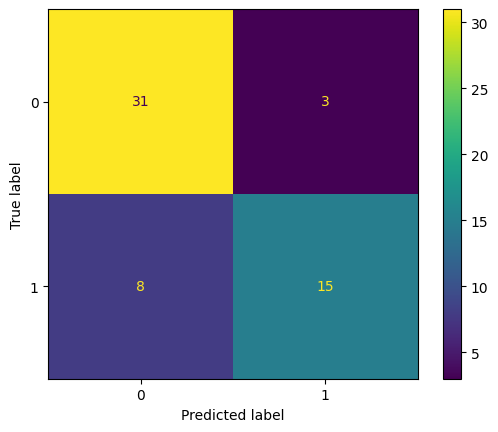

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(matrix).plot()
print(classification_report(y_test, y_pred))

In [ ]:
precision, recall, fscore, support = score(y_test, y_pred, average="macro")
print("Precision    :", format(precision))
print("Recall       :", format(recall))
print("F-Score      :", format(fscore))
print("Accuracy     :", accuracy_score(y_test, y_pred))

Precision    : 0.8141025641025641
Recall       : 0.7819693094629157
F-Score      : 0.7905111927831607
Accuracy     : 0.8070175438596491


## 4.4 - Visualisasi Word Cloud

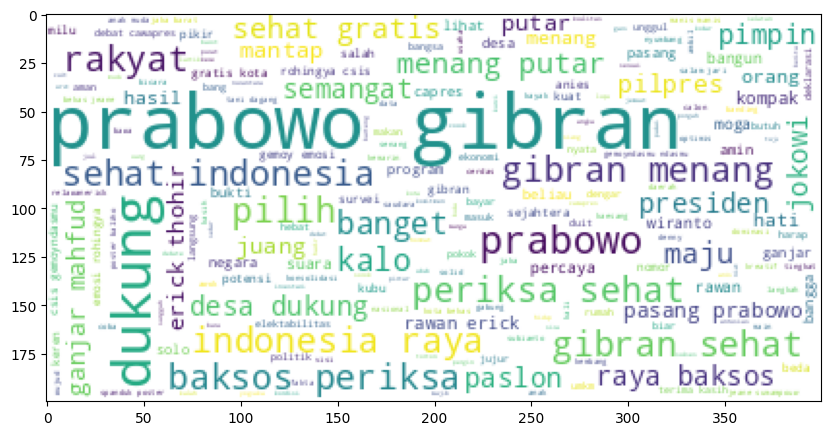

In [ ]:
positive = ' '.join(data[data['Sentiment'] == 'positive']['Cleaned'].tolist())
wordcloud = WordCloud(
    background_color = "white",
    stopwords = stop_words,
    min_font_size = 0
).generate(positive)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.show()

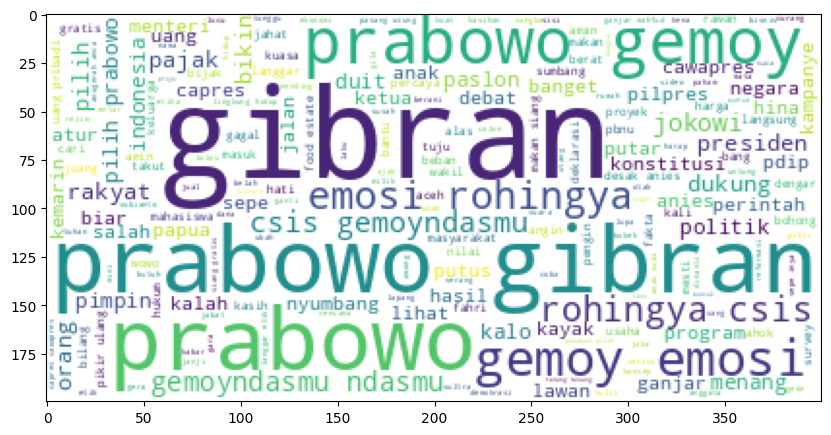

In [ ]:
negative = ' '.join(data[data['Sentiment'] == 'negative']['Cleaned'].tolist())
wordcloud = WordCloud(
    background_color = "white",
    stopwords = stop_words,
    min_font_size = 0
).generate(negative)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.show()